In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [9]:
all_data=pd.read_csv("OMX_Nordic_40.csv")
all_data["Date"]=pd.to_datetime(all_data["Date"],format="%Y-%m-%d")
display(all_data)
# plt.plot(all_data["Date"],all_data["High price"])
# plt.plot(all_data["Date"],all_data["Low price"])
# plt.plot(all_data["Date"],all_data["Closing price"])
# plt.show()

,Date,High price,Low price,Closing price
0,2001-12-28,NaN,NaN,1000.00
1,2002-01-02,NaN,NaN,983.52
2,2002-01-03,NaN,NaN,1024.30
3,2002-01-04,NaN,NaN,1025.50
4,2002-01-07,NaN,NaN,1020.14
...,...,...,...,...
5679,2024-04-04,2760.12,2739.26,2747.39
5680,2024-04-05,2739.58,2712.48,2738.46
5681,2024-04-08,2764.17,2736.28,2757.69
5682,2024-04-09,2762.93,2735.93,2739.41


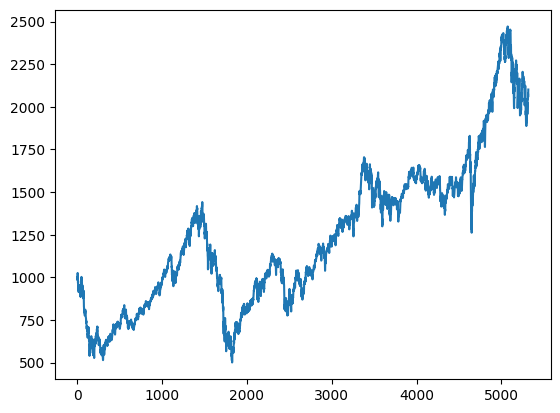

,Date,High price,Low price,Closing price
0,2001-12-28,NaN,NaN,1000.00
1,2002-01-02,NaN,NaN,983.52
2,2002-01-03,NaN,NaN,1024.30
3,2002-01-04,NaN,NaN,1025.50
4,2002-01-07,NaN,NaN,1020.14
...,...,...,...,...
5314,2022-11-01,2079.87,2043.30,2048.22
5315,2022-11-02,2081.32,2055.94,2077.40
5316,2022-11-03,2059.60,2044.01,2057.29
5317,2022-11-04,2096.74,2069.27,2083.26


In [10]:
##Split the training data and the validation data
validation_data = all_data["Closing price"].tail(365)
data = all_data["Closing price"].head(-365)

plt.plot(data)
plt.show()

all_data.head(-365)

In [11]:
#We notice a few wrong values (fixable), and two series starts only from 2007
#We notice 2008 global crisis and 2020 Covid-19 pandemic. When crisis it is hard to predict... Maybe we should consider only stable periods (i.e. after 2009)? Or maybe go to a more stable scale such as log?

In [12]:
# #Zooming in looking for periodicty
# first_samples=data.head(2000)
# plt.plot(first_samples["Date"],first_samples["Closing price"])
# plt.show()

## Cleaning the data

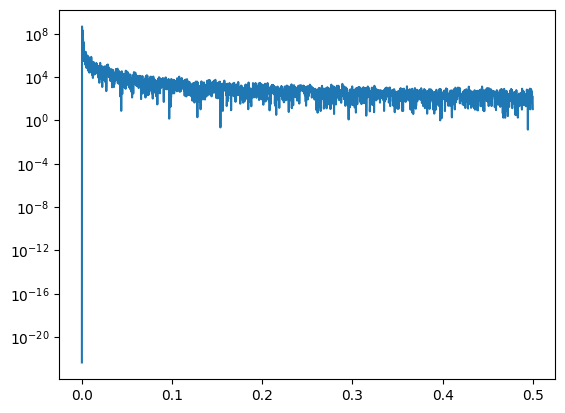

Peaks at 0.00018800526414739614 with power 466942006.2927971


In [13]:
from scipy.signal import periodogram
f, Pxx = periodogram(data)
plt.plot(f,Pxx)
plt.yscale("log")
plt.show()
peaks = np.argmax(Pxx)
print(f"Peaks at {f[peaks]} with power {Pxx[peaks]}")

###Detrend the Data

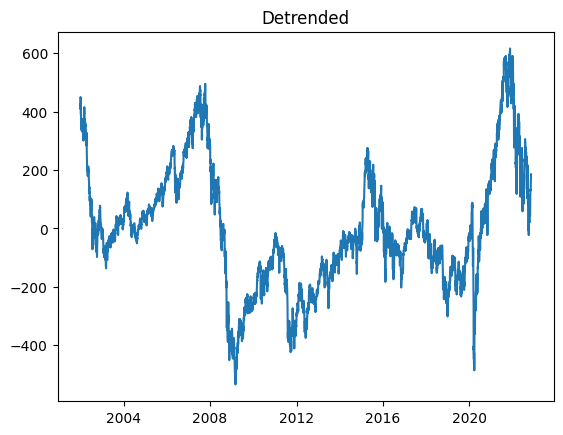

0        574.914508
1        575.166755
2        575.419003
3        575.671250
4        575.923497
           ...     
5314    1915.357070
5315    1915.609318
5316    1915.861565
5317    1916.113813
5318    1916.366060
Name: Closing price, Length: 5319, dtype: float64
3.3333061415699268
574.9145078573476


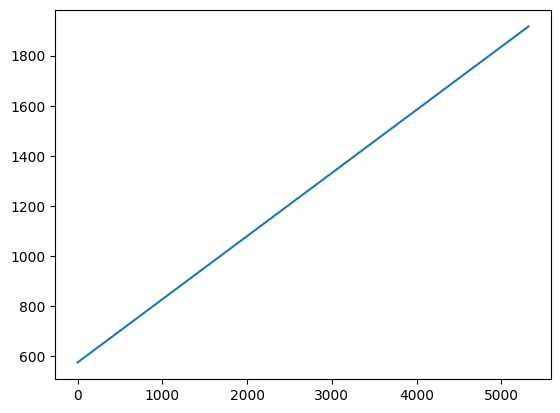

In [79]:
from statsmodels.tsa.tsatools import detrend
detrended = detrend(data)

plt.plot(all_data["Date"].head(-365), detrended)
plt.title("Detrended")
plt.show()

trend= data - detrended
print(trend)
trend_coefficient = trend[5318] /  trend[0]
trend_const = trend.iloc[0]
print(trend_coefficient)
print(trend_const)
plt.plot(trend.index,trend)
plt.show()

In [15]:
# ADF Test
from statsmodels.tsa.stattools import adfuller
result = adfuller(detrended)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.753357
p-value: 0.065251
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [16]:
# KPSS test
from statsmodels.tsa.stattools import kpss
result = kpss(detrended)
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))


KPSS Statistic: 1.028746
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


<ipython-input-16-90c9c09c54b9>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(detrended)


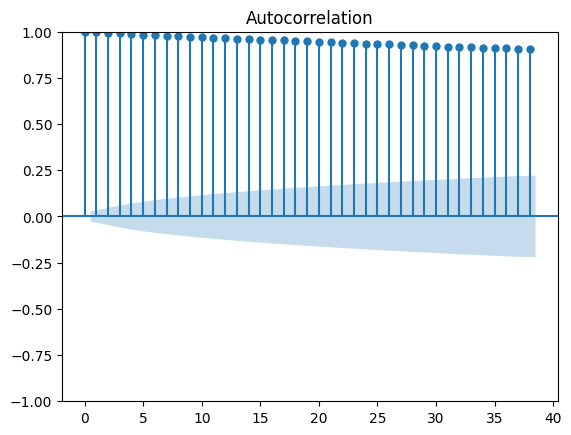

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(detrended)
plt.show()

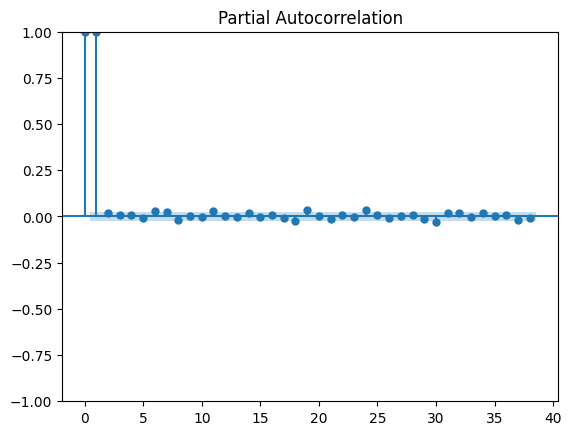

In [18]:
plot_pacf(detrended)
plt.show()

## Differencing

            Closing price diff
Date                          
2002-01-03               57.26
2002-01-04              -39.58
2002-01-07               -6.56
2002-01-08              -31.25
2002-01-09               31.75
2002-01-10               -8.19
2002-01-11               26.87
2002-01-14              -57.31
2002-01-15               42.86
2002-01-16              -11.92


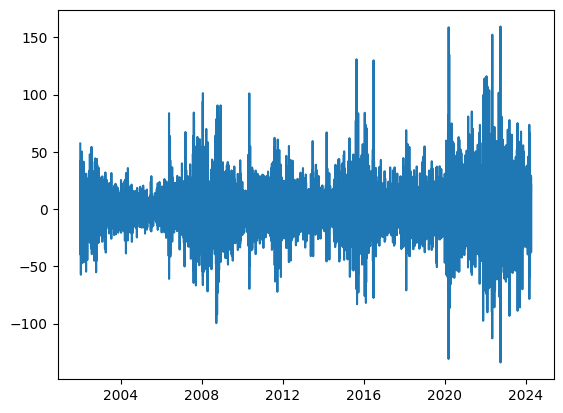

In [19]:
## Differencing 2 time
all_data["Closing price diff"] = all_data["Closing price"].diff()
all_data["Closing price diff"] = all_data["Closing price diff"].diff()

# create a new dataframe with only the closing price diff and date
all_diff_data = all_data[["Date", "Closing price diff"]].dropna()
all_diff_data.set_index("Date", inplace=True)
print(all_diff_data.head(10))

# plot the diff data
plt.plot(all_diff_data)
plt.show()

In [20]:
diff_data = all_diff_data["Closing price diff"].head(-365)

# ADF test
from statsmodels.tsa.stattools import adfuller
result = adfuller(diff_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -21.062205
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [21]:
# KPSS test
from statsmodels.tsa.stattools import kpss
result = kpss(diff_data)
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))


KPSS Statistic: 0.020605
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


<ipython-input-21-1a3290ad809f>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(diff_data)


The data before 2009 was truncated in the following section

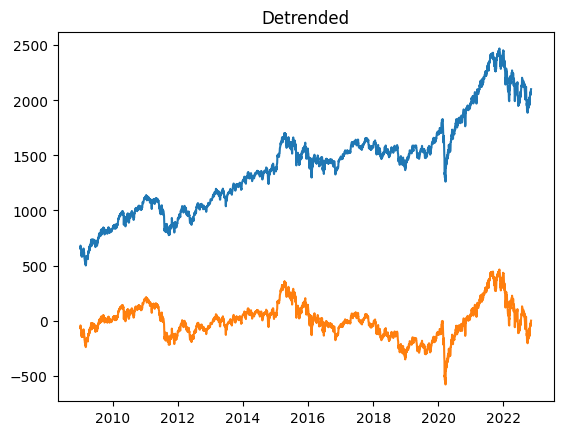

ADF Statistic: -20.034280
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

KPSS Statistic: 0.045665
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


<ipython-input-22-1fc1e7b3f9ba>:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(diff_data_2)


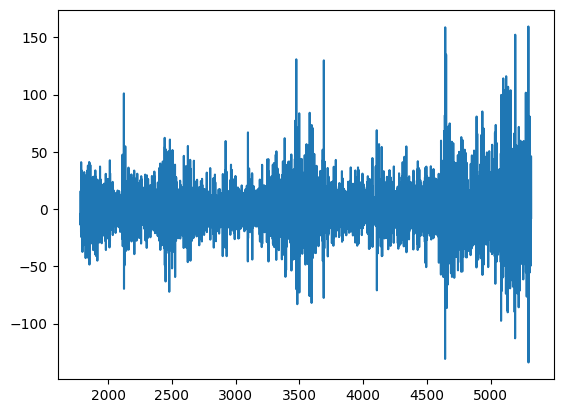

In [22]:
##start from 2009:
split_date = '2009-01-01'
all_data_2 = all_data.loc[all_data["Date"] > split_date]


#all_data_2["Closing price sq"] = all_data_2["Closing price"]**(0.5)

train_data_2 = all_data_2["Closing price"].head(-365)
plt.plot(all_data_2["Date"].head(-365), train_data_2)


##detrend data
train_data_2 = detrend(train_data_2)
plt.plot(all_data_2["Date"].head(-365), train_data_2)
plt.title("Detrended")
plt.show()

##differencing 2 times
diff_data_2 = train_data_2.diff().dropna()
diff_data_2 = diff_data_2.diff().dropna()


##ADF test
result = adfuller(diff_data_2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# KPSS test
from statsmodels.tsa.stattools import kpss
result = kpss(diff_data_2)
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))


plt.plot(diff_data_2)

## Fitting ARMA models

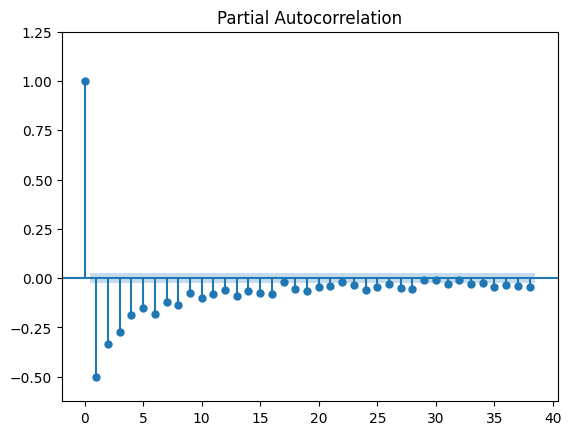

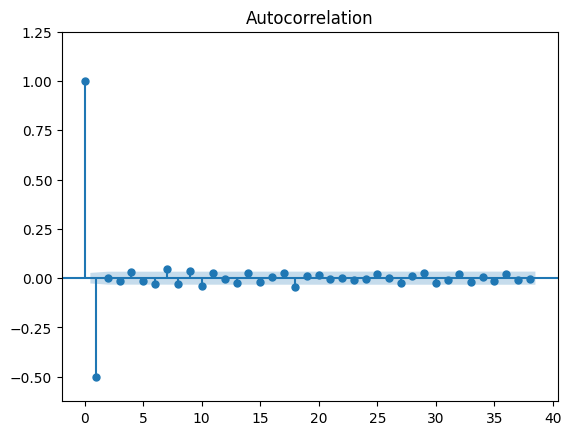

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

##Plot the acf and pacf to determine the order
_ =plot_pacf(diff_data, alpha = 0.05, auto_ylims = True)
_ =plot_acf(diff_data, alpha = 0.05, auto_ylims= True)
##The ACF decays geometrically, indicating that an ARMA model is suitable for fitting

In [24]:
maxp=3
maxq=5

aiccs=np.zeros((maxp+1,maxq+1))
aics=np.zeros((maxp+1,maxq+1))
bics=np.zeros((maxp+1,maxq+1))

for p in range(0,maxp+1):
  for q in range(0,maxq+1):
    model = ARIMA(diff_data, order=(p, 0 ,q)).fit(method= "innovations_mle")

    aiccs[p,q]=model.aicc
    aics[p,q]=model.aic
    bics[p,q]=model.bic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [25]:
print(aiccs)

for q in range(maxq):
    print("$q=",q,"$&",end="")
print("$q=",maxq,"$\\\\")
for p in range(maxp+1):
    print("$p=",p,"$&",end="")
    for q in range(maxq):
        print("{:.2f}".format(aiccs[p,q]),"&",end="")
    print("{:.2f}".format(aiccs[p,maxq]),"\\\\")

[[48347.3212914  44587.65012313 44588.77737158 44588.79994686
  44589.31272244 44590.63898502]
 [46822.27539899 44588.35731563 44591.07016046 44590.74825332
  44591.95317919 44591.35426942]
 [46197.53133451 44588.84837336 44590.81446249 44578.18284637
  44578.38960783 44576.40271851]
 [45794.48222499 44589.18367702 44590.22962486 44578.49710963
  44582.89384514 44586.07468599]]
$q= 0 $&$q= 1 $&$q= 2 $&$q= 3 $&$q= 4 $&$q= 5 $\\
$p= 0 $&48347.32 &44587.65 &44588.78 &44588.80 &44589.31 &44590.64 \\
$p= 1 $&46822.28 &44588.36 &44591.07 &44590.75 &44591.95 &44591.35 \\
$p= 2 $&46197.53 &44588.85 &44590.81 &44578.18 &44578.39 &44576.40 \\
$p= 3 $&45794.48 &44589.18 &44590.23 &44578.50 &44582.89 &44586.07 \\


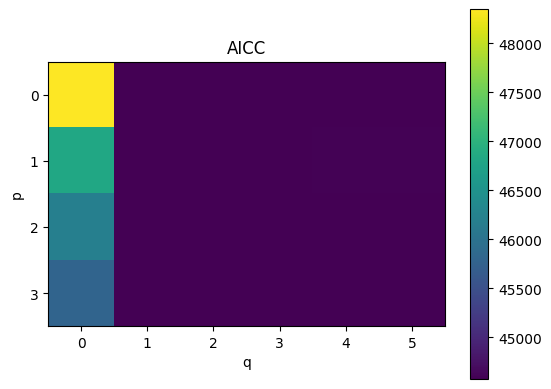

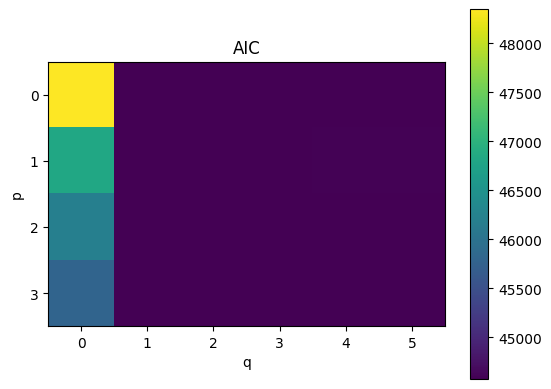

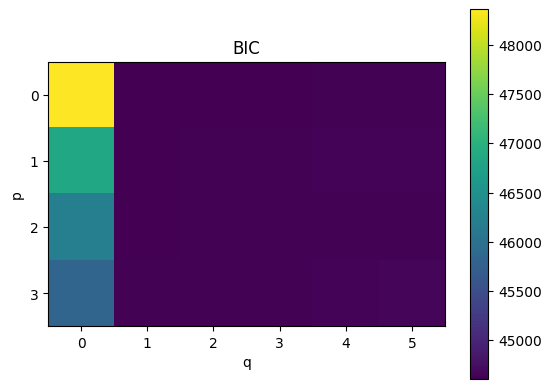

In [26]:
plt.imshow(aiccs,vmin=aiccs.min(),vmax=aiccs.max())
plt.yticks(range(maxp+1),range(maxp+1))
plt.xticks(range(maxq+1),range(maxq+1))
plt.colorbar()
plt.title("AICC")
plt.xlabel("q")
plt.ylabel("p")
plt.show()
plt.imshow(aics,vmin=aics.min(),vmax=aics.max())
plt.yticks(range(maxp+1),range(maxp+1))
plt.xticks(range(maxq+1),range(maxq+1))
plt.colorbar()
plt.title("AIC")
plt.xlabel("q")
plt.ylabel("p")
plt.show()
plt.imshow(bics,vmin=bics.min(),vmax=bics.max())
plt.yticks(range(maxp+1),range(maxp+1))
plt.xticks(range(maxq+1),range(maxq+1))
plt.colorbar()
plt.title("BIC")
plt.xlabel("q")
plt.ylabel("p")
plt.show()

In [27]:
# best_params=np.unravel_index(np.argmin(aiccs), aiccs.shape)
best_params = (2, 5)
print("Best params:  p =",best_params[0],",  q =",best_params[1])
best_model=ARIMA(diff_data, order=(best_params[0], 0 ,best_params[1])).fit(method= "innovations_mle")
print("Best params using innovations")
print("ar:",best_model.arparams)
print("ma:",best_model.maparams)

Best params:  p = 2 ,  q = 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best params using innovations
ar: [-1.56606203 -0.93162258]
ma: [ 0.55239851 -0.6606182  -0.95437622  0.03320365  0.0296036 ]


In [28]:
##summary
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Closing price diff   No. Observations:                 5317
Model:                 ARIMA(2, 0, 5)   Log Likelihood              -22279.184
Date:                Fri, 03 May 2024   AIC                          44576.369
Time:                        22:26:23   BIC                          44635.577
Sample:                             0   HQIC                         44597.056
                               - 5317                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      1.061      0.289      -0.000       0.000
ar.L1         -1.5661      0.023    -68.071      0.000      -1.611      -1.521
ar.L2         -0.9316      0.023    -41.258      0.000      -0.976      -0.887
ma.L1          0.5524      0.026     21.222      0.000       0.501       0.603
ma.L2         -0.6606      0.021    -31.539      0.000      -0.702      -0.620
ma.L3         -0.9544      0.023    -42.262      0.000      -0.999      -0.910
ma.L4          0.0332      0.012      2.751      0.006       0.010       0.057
ma.L5          0.0296      0.011      2.770      0.006       0.009       0.051
sigma2       254.9086      3.170     80.419      0.000     248.696     261.121
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6312.52
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

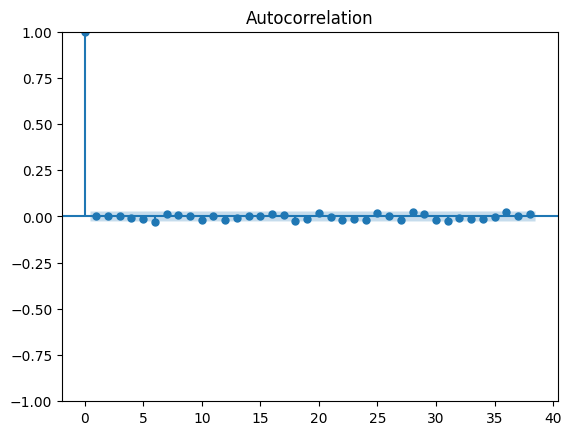

In [29]:
_=plot_acf(best_model.resid, alpha = 0.05)

In [30]:
##Residual Analysis
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import jarque_bera

acorr_ljungbox(best_model.resid)

,lb_stat,lb_pvalue
1,0.000019,0.996537
2,0.000027,0.999987
3,0.020710,0.999212
4,0.325389,0.988117
5,1.561767,0.905834
6,5.498112,0.481685
7,6.388675,0.495168
8,6.586310,0.581851
9,6.622420,0.676364
10,9.005351,0.531596


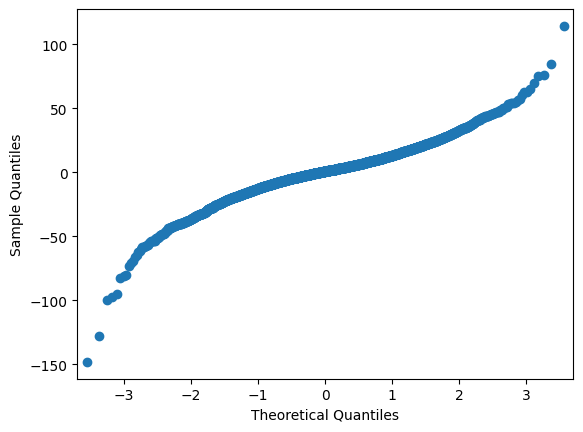

In [31]:
##QQ Plot
_=qqplot(best_model.resid)

In [32]:
jarque_bera(best_model.resid)

(6288.458182762765, 0.0, -0.49509746326385023, 8.234931218689564)

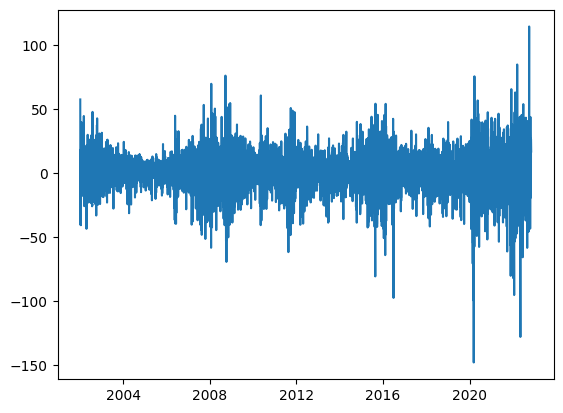

In [33]:
plt.plot(best_model.resid)

##Forcasting

In [80]:
def forecast_out(n):
	forecasts = best_model.get_forecast(n).summary_frame()
	start = len(data)
	print(start)
	end = start + n
	forecasts['trend'] = trend_const + trend_coefficient * np.arange(start, end)
	forecasts['stationary'] = forecasts['mean']

	forecasts["mean"].iloc[0] = detrended[5317]

	'''inverse_1 = forecasts["mean"].cumsum()
	print(inverse_1)
	inverse = inverse_1.cumsum()
	print(inverse)
	print(forecasts["trend"])
	forecasts["mean"] = inverse + forecasts["trend"]
'''
	forecasts['mean'] += inverse + forecasts['trend']
	forecasts['mean_ci_lower'] +=  forecasts['trend']
	forecasts['mean_ci_upper'] +=  forecasts['trend']
	return forecasts


best_model.get_forecast(1000).summary_frame()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Closing price diff,mean,mean_se,mean_ci_lower,mean_ci_upper
5317,-19.643621,15.966910,-50.938189,11.650946
5318,2.066242,22.733909,-42.491401,46.623884
5319,-0.462353,22.734037,-45.020247,44.095541
5320,0.126875,22.734073,-44.431089,44.684840
5321,0.723375,22.743788,-43.853630,45.300380
...,...,...,...,...
6312,0.000129,22.807914,-44.702561,44.702819
6313,0.000129,22.807914,-44.702561,44.702819
6314,0.000129,22.807914,-44.702561,44.702819
6315,0.000129,22.807914,-44.702561,44.702819


In [81]:
forecasts = forecast_out(1000)
forecasts

5319
5317    167.146187
5318    169.212429
5319    168.750076
5320    168.876952
5321    169.600327
           ...    
6312    169.178082
6313    169.178211
6314    169.178340
6315    169.178469
6316    169.178598
Name: mean, Length: 1000, dtype: float64
5317       167.146187
5318       336.358617
5319       505.108693
5320       673.985645
5321       843.585972
            ...      
6312    168435.367181
6313    168604.545392
6314    168773.723732
6315    168942.902201
6316    169112.080799
Name: mean, Length: 1000, dtype: float64
5317    18304.769875
5318    18308.103181
5319    18311.436487
5320    18314.769793
5321    18318.103099
            ...     
6312    21621.409486
6313    21624.742792
6314    21628.076098
6315    21631.409404
6316    21634.742710
Name: trend, Length: 1000, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Closing price diff,mean,mean_se,mean_ci_lower,mean_ci_upper,trend,stationary
5317,36943.832125,15.966910,18253.831686,18316.420821,18304.769875,-19.643621
5318,37288.923596,22.733909,18265.611780,18354.727065,18308.103181,2.066242
5319,37633.090360,22.734037,18266.416240,18355.532028,18311.436487,-0.462353
5320,37977.510876,22.734073,18270.338704,18359.454634,18314.769793,0.126875
5321,38323.378142,22.743788,18274.249470,18363.403480,18318.103099,0.723375
...,...,...,...,...,...,...
6312,380113.553333,22.807914,21576.706925,21666.112305,21621.409486,0.000129
6313,380458.576367,22.807914,21580.040231,21669.445611,21624.742792,0.000129
6314,380803.599660,22.807914,21583.373537,21672.778917,21628.076098,0.000129
6315,381148.623210,22.807914,21586.706843,21676.112224,21631.409404,0.000129


'plt.plot(forecasts.index, forecasts[\'mean\'])\nplt.fill_between(forecasts.index, forecasts[\'mean_ci_lower\'],forecasts[\'mean_ci_upper\'], alpha = 0.1)\nplt.legend([\'Observed data\',\'Predicted mean\', \'95/% Confidence interval\'])\nplt.xlabel(\'Date\')\nplt.ylabel(\'Closing price\')\nplt.savefig("B_forecasting")\nfig.show()'

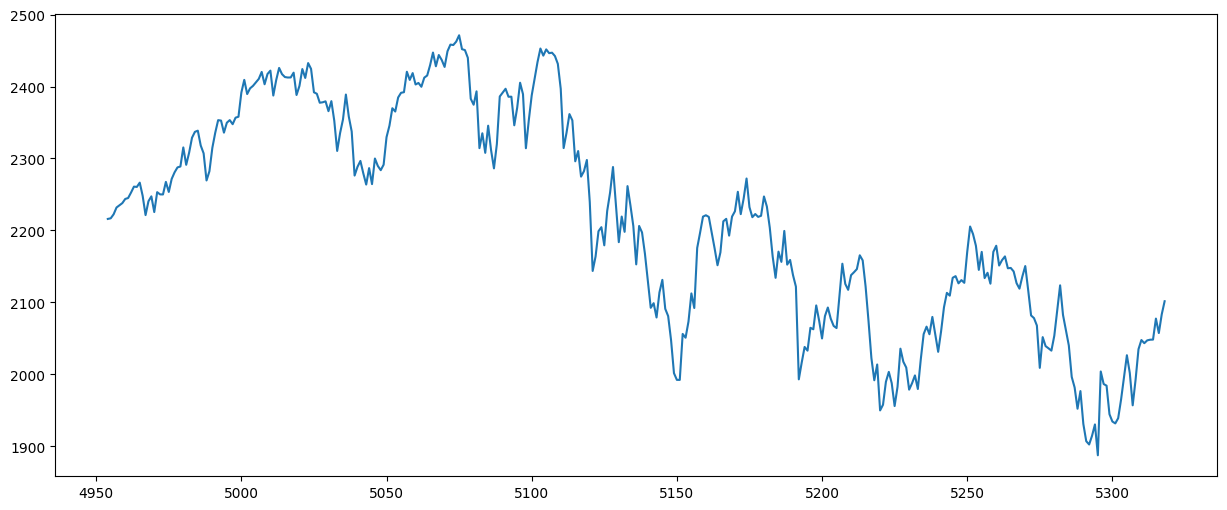

In [83]:


fig = plt.figure(figsize=(15, 6))
plt.plot(data.tail(365).index,data.tail(365))
'''plt.plot(forecasts.index, forecasts['mean'])
plt.fill_between(forecasts.index, forecasts['mean_ci_lower'],forecasts['mean_ci_upper'], alpha = 0.1)
plt.legend(['Observed data','Predicted mean', '95/% Confidence interval'])
plt.xlabel('Date')
plt.ylabel('Closing price')
plt.savefig("B_forecasting")
fig.show()'''